In [ ]:
!kaggle competitions download -c playground-series-s5e2
!unzip *.zip

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import holidays
import missingno


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

KAGGLE_RUN = False
if KAGGLE_RUN:
    working_dir = Path('/kaggle/input/playground-series-s5e2')
else:
    working_dir = Path().cwd()


In [2]:
train_df = pd.read_csv(working_dir/'train.csv')
test_df = pd.read_csv(working_dir/'test.csv')

train_df

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...,...
299995,299995,Adidas,Leather,Small,9.0,No,No,Tote,Blue,12.730812,129.99749
299996,299996,Jansport,Leather,Large,6.0,No,Yes,Tote,Blue,26.633182,19.85819
299997,299997,Puma,Canvas,Large,9.0,Yes,Yes,Backpack,Pink,11.898250,111.41364
299998,299998,Adidas,Nylon,Small,1.0,No,Yes,Tote,Pink,6.175738,115.89080


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


In [4]:
CATEGORIC_COLUMNS = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
NUMERIC_COLUMNS = ['Compartments', 'Weight Capacity (kg)', 'Price']

In [5]:
def get_unique_vals(df:pd.DataFrame, column:str) -> None:
    print(f'{column} has the following unique entries {len(df[column].unique())}')
    print(f'{df[column].value_counts()}')
    print('-----------------------------------')


for column in CATEGORIC_COLUMNS:
    get_unique_vals(train_df, column)


Brand has the following unique entries 6
Brand
Adidas          60077
Under Armour    59992
Nike            57336
Puma            56814
Jansport        56076
Name: count, dtype: int64
-----------------------------------
Material has the following unique entries 5
Material
Polyester    79630
Leather      73416
Nylon        70603
Canvas       68004
Name: count, dtype: int64
-----------------------------------
Size has the following unique entries 4
Size
Medium    101906
Large      98643
Small      92856
Name: count, dtype: int64
-----------------------------------
Laptop Compartment has the following unique entries 3
Laptop Compartment
Yes    148342
No     144214
Name: count, dtype: int64
-----------------------------------
Waterproof has the following unique entries 3
Waterproof
Yes    148077
No     144873
Name: count, dtype: int64
-----------------------------------
Style has the following unique entries 4
Style
Messenger    100031
Tote          97438
Backpack      94561
Name: count, dt

In [6]:
train_df.describe()

,id,Compartments,Weight Capacity (kg),Price
count,300000.000000,300000.000000,299862.000000,300000.000000
mean,149999.500000,5.443590,18.029994,81.411107
std,86602.684716,2.890766,6.966914,39.039340
min,0.000000,1.000000,5.000000,15.000000
25%,74999.750000,3.000000,12.097867,47.384620
50%,149999.500000,5.000000,18.068614,80.956120
75%,224999.250000,8.000000,24.002375,115.018160
max,299999.000000,10.000000,30.000000,150.000000


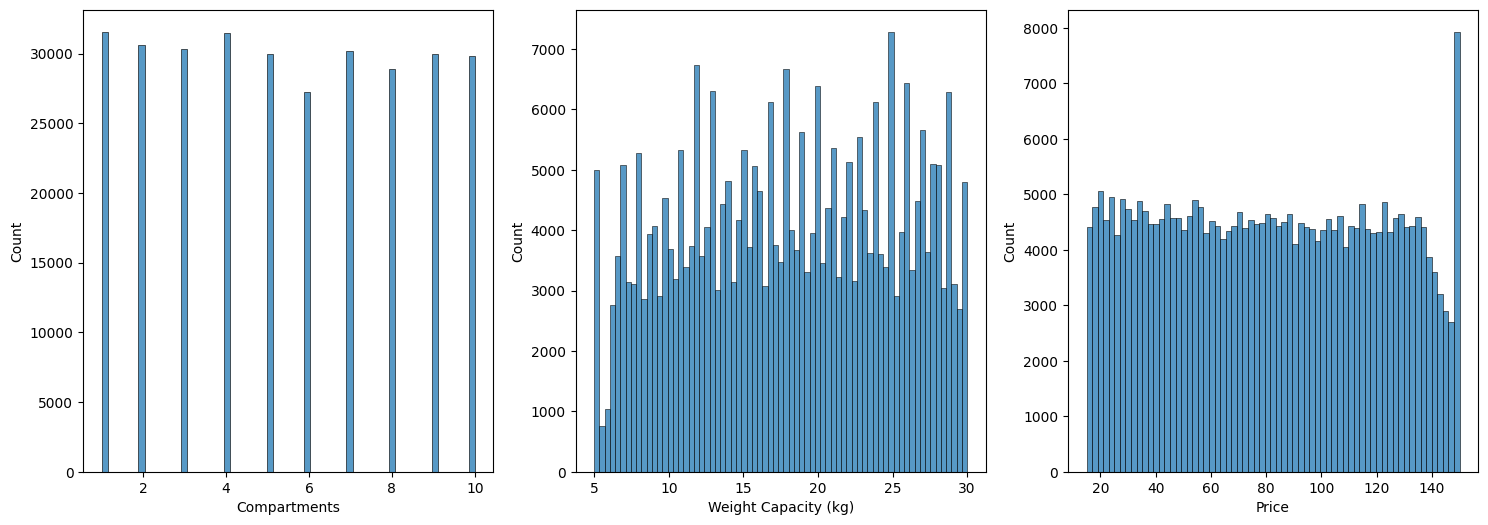

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

sns.histplot(data=train_df, x='Compartments', ax=ax[0])
sns.histplot(data=train_df, x='Weight Capacity (kg)', ax=ax[1])
sns.histplot(data=train_df, x='Price', ax=ax[2])

plt.show()

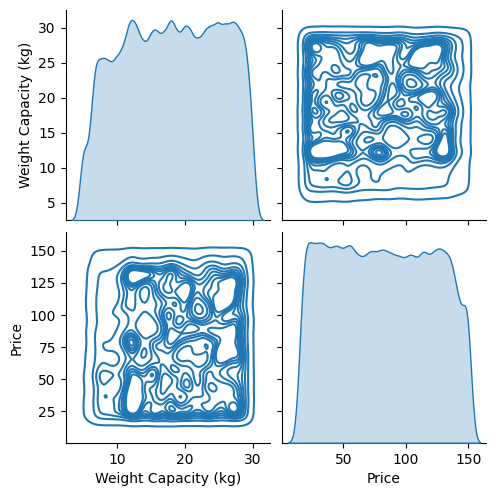

In [8]:
sns.pairplot(
    data=train_df,
    vars=[
        'Weight Capacity (kg)',
        'Price'
        ],
    kind='kde'
)

plt.show()

In [20]:

for column in CATEGORIC_COLUMNS:

    sns.catplot(data=train_df,
                x='Price',
                y=column,
                kind='boxen',
    )            
    


KeyboardInterrupt: 

: 

: 